# Juputer notebook implementation of Easy Model-Agnostic Approach for Inductive Recommendations

## I. Preparation of necessary functions

We have prepared scores for the interaction matrix. This made it possible to calculate the results of both the baselines and the proposed method

In [1]:
import pandas as pd
import numpy as np

import argparse
import os

import numpy as np
import pandas as pd
from scipy import sparse
from collections import defaultdict
from scipy import sparse as sps
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

/home/o.lashinin/.local/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [10]:
from typing import NamedTuple, Union
from abc import ABC, abstractmethod

import numpy as np


class PrepareTargetResult(NamedTuple):
    values: np.ndarray
    indices: np.ndarray


class Metric(ABC):
    """
    Abstract class with structure for all metrics in the project.
    """

    def __repr__(self) -> str:
        return "{:.4f}".format(self.get_metric_value())

    @abstractmethod
    def __call__(self, output: np.ndarray, target: np.ndarray) -> None:
        """
        Add new output and target to metric state.
        Parameters
        ----------
        output : `np.ndarray`, required
            Output from the model.
        target : `np.ndarray`, required
            True target.
        """
        raise NotImplementedError()

    @abstractmethod
    def get_metric(self, reset: bool = False) -> Union[float, int]:
        """
        Get current metric value.
        Parameters
        ----------
        reset : `bool`, optional (default = `False`)
            Whether to reset metric state or not.
            If `True` then metric's sufficient statistics return to default state.
        """
        raise NotImplementedError()

    @abstractmethod
    def reset(self) -> None:
        """Reset metric's state."""
        raise NotImplementedError()


def validate_metric_inputs(output: np.ndarray, target: np.ndarray) -> None:
    if output.shape != target.shape:
        raise IndexError(
            "Unequal sizes for output and target: "
            f"output - {output.shape}, target - {target.shape}."
        )
    if not (np.equal(target, 0) | np.equal(target, 1)).all():
        raise ValueError("Target contains values outside of 0 and 1." f"\nTarget:\n{target}")


def prepare_target(
    output: np.ndarray, target: np.ndarray, return_indices: bool = False
) -> Union[np.ndarray, PrepareTargetResult]:
    """
    Sort target by output scores.
    Parameters
    ----------
    output : `np.ndarray`, required
        Model output scores for each item.
    target : `np.ndarray`, required
        True target for each item. It is a binary tensor.
    Returns
    -------
    `Union[np.ndarray, PrepareTargetResult]`
        Target sorted by output scores in descending order.
    """
    validate_metric_inputs(output, target)
    # Define order by sorted output scores.
    indices = np.argsort(-output, axis=-1)
    sorted_target = np.take_along_axis(target, indices=indices, axis=-1)
    return PrepareTargetResult(sorted_target, indices) if return_indices else sorted_target

In [11]:
from typing import List
import numpy as np


class NDCG(Metric):
    """
    Implementation of `Normalized Discounter Cumulative Gain` Metric.
    Graded relevance as a measure of  usefulness, or gain, from examining a set of items.
    Gain may be reduced at lower ranks.
    Parameters
    ----------
    topk : `int`, required
        Top-K elements to take into account.
    gain_function : `str`, optional (default = `"exp"`)
        Pick the gain function for the ground truth labels.
        Two options:
        - exp
        - linear
    """

    def __init__(self, topk: List[int], gain_function: str = "exp") -> None:
        super().__init__()
        assert all(x > 0 for x in topk), f"Invalid topk value: {topk}"
        assert gain_function in (
            "exp",
            "linear",
        ), f"Invalid gain_function value: {gain_function}"
        self._topk = topk
        self._total_ndcg = {f"ndcg@{k}": 0 for k in topk}
        self._total_count = 0
        self._dcg = exp_dcg if gain_function == "exp" else linear_dcg

    def _compute(self, output: np.ndarray, target: np.ndarray) -> float:
        topk = [min(target.shape[-1], x) - 1 for x in self._topk]
        # non_empty_sum ~ (batch)
        non_empty_sum = target.sum(axis=-1)
        # target_sorted_by_output ~ (users, items)
        target_sorted_by_output = prepare_target(output, target)
        ideal_target = prepare_target(target, target)
        # ideal_dcg ~ (users, items)
        ideal_dcg = self._dcg(ideal_target).cumsum(axis=-1)
        # prediction_dcg ~ (users, items)
        prediction_dcg = self._dcg(target_sorted_by_output).cumsum(axis=-1)
        # ndcg_score ~ (users, items)
        ndcg_score = prediction_dcg / ideal_dcg
        ndcg_score[ideal_dcg == 0] = 0.0
        # Compute an average excluding samples with all zeros
        # u - users, l - len(topk)
        mean_ndcg_score = non_empty_average(
            np.einsum("ul->lu", ndcg_score[:, topk]),
            batch_sum=non_empty_sum,
        )
        return mean_ndcg_score

    def __call__(self, output: np.ndarray, target: np.ndarray) -> None:
        self._total_count += 1
        values = self._compute(output, target)
        for topk, value in zip(self._topk, values):
            self._total_ndcg[f"ndcg@{topk}"] += value

    def get_metric(self, reset: bool = False) -> float:
        average_ndcg = {
            ndcg_k: value / self._total_count for ndcg_k, value in self._total_ndcg.items()
        }
        if reset:
            self.reset()
        return average_ndcg

    def reset(self) -> None:
        self._total_ndcg = {f"ndcg@{k}": 0 for k in self._topk}
        self._total_count = 0


In [12]:
from typing import List
import numpy as np

class Recall(Metric):
    def __init__(self, topk: List[int]) -> None:
        assert all(x > 0 for x in topk), f"Invalid topk value: {topk}"
        self._total_recall = {f"recall@{k}": 0 for k in topk}
        self._total_count = 0
        self._topk = topk

    def _compute(self, output: np.ndarray, target: np.ndarray) -> float:
        topk = [min(target.shape[-1], x) - 1 for x in self._topk]
        # non_empty_sum ~ (batch)
        non_empty_sum = target.sum(axis=-1)
        # target_sorted_by_output ~ (users, topk)
        target_sorted_by_output = prepare_target(output, target)
        recall_score = np.einsum(
            "ul->lu", target_sorted_by_output.cumsum(axis=-1)[:, topk]
        ) / target.sum(axis=-1)
        # Compute an average excluding samples with all zeros
        # recall_score ~ (topk)
        recall_score = non_empty_average(nan_to_num(recall_score), batch_sum=non_empty_sum)
        return recall_score

    def __call__(self, output: np.ndarray, target: np.ndarray) -> None:
        self._total_count += 1
        values = self._compute(output, target)
        for topk, recall in zip(self._topk, values):
            self._total_recall[f"recall@{topk}"] += recall

    def get_metric(self, reset: bool = False) -> float:
        average_recall = {
            recall_k: value / self._total_count for recall_k, value in self._total_recall.items()
        }
        if reset:
            self.reset()
        return average_recall

    def reset(self) -> None:
        self._total_recall = {f"recall@{k}": 0 for k in self._topk}
        self._total_count = 0


In [13]:
from typing import Union, List
import numpy as np


def nan_to_num(tensor: np.ndarray, nan: float = 0.0) -> np.ndarray:
    return np.where(
        np.logical_or(np.isnan(tensor), np.isinf(tensor)),
        np.full_like(tensor, fill_value=nan),
        tensor,
    )


def exp_dcg(tensor: np.ndarray) -> np.ndarray:
    """Calculate `Exponential` gain function for `NDCG` Metric."""
    gains = (2**tensor) - 1
    discounts = 1 / np.log2(np.arange(0, tensor.shape[-1], dtype=np.float32) + 2.0)
    return gains * discounts


def linear_dcg(tensor: np.ndarray) -> np.ndarray:
    """Calculate `Linear` gain function for `NDCG` Metric."""
    discounts = 1 / np.log2(np.arange(0, tensor.shape[-1], dtype=np.float32) + 1.0)
    discounts[0] = 1
    return tensor * discounts


def non_empty_average(
    x: np.ndarray, batch_sum: np.ndarray, axis: Union[int, List[int]] = -1
) -> np.ndarray:
    num_non_empty_seq = (batch_sum > 0).astype(np.float32).sum().clip(min=1e-13)
    return nan_to_num((x / num_non_empty_seq)).sum(axis=axis)

In [66]:
from  annoy import AnnoyIndex
from tqdm import tqdm

class SemiPers:
    
    def __init__(self, train_inters, train_preds, metric='angular', method='avg'):
        
        self.train_inters = train_inters
        self.train_preds = train_preds
        self.metric = metric
        self.method=method
        
        self.index = AnnoyIndex(train_inters.shape[1], metric)
        for i in tqdm(range(train_inters.shape[0])):
            if train_inters[i].sum() == 0:
                print('skipped')
                continue
            self.index.add_item(i, train_inters[i])
            
        self.index.build(10) # 10 trees
        
        
    def predict(self, batch, nngb=1):
        
        ids_of_similar_users = []

        for user in range(batch.shape[0]):
            user_vector = batch[user]
            min_indexs = self.index.get_nns_by_vector(user_vector, nngb+1, include_distances=False)[1:]
            ids_of_similar_users.append(min_indexs)        
            
            if user % 1000 == 0 and user:
                print(f'{user} processed out of {batch.shape[0]}')

        ids_of_similar_users = np.array(ids_of_similar_users)
        final_preds = self.train_preds[ids_of_similar_users.astype(np.int32)].sum(1)
        return final_preds

    

## II. Recommendation quality

In [73]:
global_dict_gen = {}
nngb_list = [1,5, 10, 15, 20] 

datasets = ['ml-1m','gowalla','yelp2018']

for dataset in datasets:
    
    train_matrix = sps.load_npz(f'../assets/clean/{dataset}/interactions.train.npz').toarray()
    
    output_valid = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_output.valid.npz').toarray()
    output_test = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_output.test.npz').toarray()

    input_valid = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_input.valid.npz').toarray()
    input_test = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_input.test.npz').toarray()
    
    print(output_valid.shape, output_test.shape, input_valid.shape, input_test.shape)
    for model in ['top_popular','multivae','ease']:
        print(model)
        recall = Recall(topk=[10, 20, 50, 100])
        ndcg = NDCG(topk=[10, 20, 50, 100])

        valid_scores = np.load(f'../assets/clean/{dataset}/{dataset}_{model}/valid_preds.npy')
        test_scores = np.load(f'../assets/clean/{dataset}/{dataset}_{model}/test_preds.npy')

        valid_scores[input_valid>0] = -np.inf
        test_scores[input_test>0] = -np.inf

        ndcg(test_scores, output_test)
        recall(test_scores, output_test)

        for metric in (recall, ndcg):
            values = metric.get_metric()
            for key in values.keys():
                global_dict_gen[(dataset, model, key)] = values[key]
                
                
    ''' SP '''
    for model in ['multivae','ials','ease']:
        print(model)

        train_preds =  np.load(f'../assets/clean/{dataset}/{dataset}_{model}/train_preds.npy')
        
        # hyper params tuning
        max_recall = 0
        best_nngb = -1
        best_m = -1
        for m in ['angular','euclidean','hamming']:
        
            sp = SemiPers(train_matrix, train_preds,metric=m)
            for nngb in nngb_list:
            
                recall = Recall(topk=[10, 20, 50, 100])
                ndcg = NDCG(topk=[10, 20, 50, 100])
                
                preds = sp.predict(input_valid, nngb=nngb)
                preds[input_valid>0] = -np.inf
                
                recall(preds, output_valid)
                rmetric = recall.get_metric()
                
                if max_recall < rmetric['recall@20']:
                    max_recall = rmetric['recall@20']
                    best_nngb = nngb
                    best_m = m
                    
        print(model, best_nngb, best_m)
        # testing           
        recall = Recall(topk=[10, 20, 50, 100])
        ndcg = NDCG(topk=[10, 20, 50, 100])
        sp = SemiPers(train_matrix, train_preds,metric=best_m)

        preds = sp.predict(input_test, nngb=best_nngb)
        preds[input_test>0] = -np.inf

        ndcg(preds, output_test)
        recall(preds, output_test)
        
        for metric in (recall, ndcg):
            values = metric.get_metric()
            for key in values.keys():
                global_dict_gen[(dataset, 'ESPRec_'+"{"+model+'}', key)] = values[key]
                



(593, 3260) (638, 3260) (593, 3260) (638, 3260)
top_popular
multivae
ease
multivae


100%|██████████| 4809/4809 [00:02<00:00, 2363.26it/s]


multivae 5 angular


100%|██████████| 4809/4809 [00:02<00:00, 2255.99it/s]


ials


100%|██████████| 4809/4809 [00:02<00:00, 2305.11it/s]


ials 1 euclidean


100%|██████████| 4809/4809 [00:02<00:00, 2195.51it/s]


ease


100%|██████████| 4809/4809 [00:02<00:00, 2107.10it/s]


ease 1 euclidean


100%|██████████| 4809/4809 [00:02<00:00, 2274.65it/s]


(1031, 40981) (980, 40981) (1031, 40981) (980, 40981)
top_popular
multivae
ease
multivae


100%|██████████| 7989/7989 [00:38<00:00, 205.31it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031


100%|██████████| 7989/7989 [00:38<00:00, 207.21it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031


100%|██████████| 7989/7989 [00:36<00:00, 216.78it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
multivae 10 angular


100%|██████████| 7989/7989 [00:38<00:00, 208.95it/s]


ials


100%|██████████| 7989/7989 [00:38<00:00, 205.12it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031


100%|██████████| 7989/7989 [00:38<00:00, 209.15it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031


100%|██████████| 7989/7989 [00:36<00:00, 216.79it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
ials 15 angular


100%|██████████| 7989/7989 [00:38<00:00, 207.56it/s]


ease


100%|██████████| 7989/7989 [00:38<00:00, 207.52it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031


100%|██████████| 7989/7989 [00:38<00:00, 209.38it/s]


1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031
1000 processed out of 1031


100%|██████████| 7989/7989 [00:38<00:00, 208.20it/s]


(945, 38048) (1002, 38048) (945, 38048) (1002, 38048)
top_popular
multivae
ease
multivae


100%|██████████| 8053/8053 [00:35<00:00, 226.28it/s]


multivae 15 angular


100%|██████████| 8053/8053 [00:35<00:00, 224.58it/s]


1000 processed out of 1002
ials


100%|██████████| 8053/8053 [00:35<00:00, 225.25it/s]


ials 15 angular


100%|██████████| 8053/8053 [00:36<00:00, 219.95it/s]


1000 processed out of 1002
ease


100%|██████████| 8053/8053 [00:35<00:00, 228.16it/s]


ease 5 angular


100%|██████████| 8053/8053 [00:35<00:00, 225.89it/s]


1000 processed out of 1002


In [82]:
optimal_values = {('ml-1m','multivae'):0,('ml-1m','ease'):1,('ml-1m','ials'):1,
                  ('gowalla','multivae'):0,('gowalla','ease'):0,('gowalla','ials'):0,
                  ('yelp2018','multivae'):0,('yelp2018','ease'):0,('yelp2018','ials'):0}
                  

here we count average relative increases in similarity metrics

In [85]:
%%time

global_dict_gen = {}
nngb_list2 = [1,5, 10, 15, 20] 

plot_metric = 'recall@20'
datasets = ['gowalla','yelp2018']
models_include = ['multivae','ease','ials']

for dataset in datasets:
    
    global_y_values = []
    
    train_matrix = sps.load_npz(f'../assets/clean/{dataset}/interactions.train.npz').toarray()
    
    output_valid = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_output.valid.npz').toarray()
    output_test = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_output.test.npz').toarray()

    input_valid = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_input.valid.npz').toarray()
    input_test = sps.load_npz(f'../assets/clean/{dataset}/spr_interactions_input.test.npz').toarray()
    
    
    
    print(output_valid.shape, output_test.shape, input_valid.shape, input_test.shape)

                
    ''' SP Tuning '''
    

    for model in models_include:
        
        train_preds =  np.load(f'../assets/clean/{dataset}/{dataset}_{model}/train_preds.npy')
        
        metric = 'angular' if optimal_values[(dataset,model)] == 0 else 'euclidean'
        sp = SemiPers(train_matrix, train_preds,metric=metric)
        
        for nngb in tqdm(nngb_list2):
            recall = Recall(topk=[10, 20, 50, 100])
            ndcg = NDCG(topk=[10, 20, 50, 100])
            
            preds = sp.predict(input_test,nngb=nngb)
            
            preds[input_test>0] = -np.inf
            ndcg(preds, output_test)
            recall(preds, output_test)
            
            for metric in (recall, ndcg):
                values = metric.get_metric()
                for key in values.keys():
                    global_dict_gen[(dataset, 'ESPRec_'+"{"+model+'}'+f'_{nngb}', key)] = values[key]
                    if plot_metric == key:
                        global_y_values.append(values[key])
                    
    
    pattern = '''
        \\begin{figure*}[t!]
        \\begin{center}
        \\begin{tikzpicture}[scale=0.6]
        \\begin{axis}[
            %title={Average relative increase in "'''+ 'recall@20' + '''" similarity metric},
            title={},
            xlabel={Nearest Neighbor number},
            ylabel={Average relative increase, \%},
            xmin=1, xmax=''' + str(max(nngb_list2))
    pattern += ''' ,\nymin='''+str(0.95 * min(global_y_values))+''', ymax=''' + str(1.05 * max(global_y_values))+','


    pattern += '''  \n  xtick={'''+','.join(map(str,nngb_list2))+'},\n'
    pattern += '''    ytick={'''+','.join(map(str,np.linspace(min(global_y_values),1.05* max(global_y_values), 10)))+'},\n'

    pattern += '''legend pos=north west,
        ymajorgrids=true,
        grid style=dashed,
    ]
    '''


    for color, model in zip(['black','red','blue'],models_include):

        x = [(int(x[1].split('_')[-1]), global_dict_gen[x]) for x in global_dict_gen if x[0] == dataset and  'ESPRec_{'+model+'}_' in x[1] and x[2] == plot_metric]
        x = sorted(x, key=lambda x: x[0])
        y = [t[1] for t in x]
        x = [t[0] for t in x]


        pattern += f'''
        \\addplot[
            color={color},
            mark=square,
            ]
            coordinates '''

        pattern += '{('+')('.join([f'{x1},{y1}' for x1, y1 in zip(x, y)])+')'
        pattern += '''};\n \\addlegendentry{'''+model+'''}'''


    pattern += '''\\end{axis}'''


    print(pattern)


(1031, 40981) (980, 40981) (1031, 40981) (980, 40981)


100%|██████████| 5/5 [14:53<00:00, 178.71s/it]



        \begin{figure*}[t!]
        \begin{center}
        \begin{tikzpicture}[scale=0.6]
        \begin{axis}[
            %title={Average relative increase in "recall@20" similarity metric},
            title={},
            xlabel={Nearest Neighbor number},
            ylabel={Average relative increase, \%},
            xmin=1, xmax=20 ,
ymin=0.07491430298395312, ymax=0.11308937593696096,  
  xtick={1,5,10,15,20},
    ytick={0.07885716103574013,0.08266074046920911,0.0864643199026781,0.09026789933614707,0.09407147876961605,0.09787505820308504,0.10167863763655402,0.105482217070023,0.10928579650349197,0.11308937593696096},
legend pos=north west,
        ymajorgrids=true,
        grid style=dashed,
    ]
    
        \addplot[
            color=black,
            mark=square,
            ]
            coordinates {(1,0.07885716103574013)(5,0.1006775320402736)(10,0.10655483059683389)(15,0.10770416755901044)(20,0.10489401314844651)};
 \addlegendentry{multivae}
        \addplot[
         

  0%|          | 0/5 [00:00<?, ?it/s]

1000 processed out of 1002


 20%|██        | 1/5 [02:46<11:06, 166.58s/it]

1000 processed out of 1002


 40%|████      | 2/5 [05:35<08:23, 167.91s/it]

1000 processed out of 1002


 60%|██████    | 3/5 [08:23<05:35, 167.98s/it]

1000 processed out of 1002


 80%|████████  | 4/5 [11:14<02:49, 169.05s/it]

1000 processed out of 1002


  0%|          | 0/5 [00:00<?, ?it/s]

1000 processed out of 1002


 20%|██        | 1/5 [02:47<11:09, 167.47s/it]

1000 processed out of 1002


 40%|████      | 2/5 [05:35<08:22, 167.52s/it]

1000 processed out of 1002


 60%|██████    | 3/5 [08:23<05:35, 167.80s/it]

1000 processed out of 1002


 80%|████████  | 4/5 [11:11<02:48, 168.08s/it]

1000 processed out of 1002


  0%|          | 0/5 [00:00<?, ?it/s]

1000 processed out of 1002


 20%|██        | 1/5 [02:46<11:05, 166.42s/it]

1000 processed out of 1002


 40%|████      | 2/5 [05:33<08:20, 166.69s/it]

1000 processed out of 1002


 60%|██████    | 3/5 [08:22<05:35, 167.76s/it]

1000 processed out of 1002


 80%|████████  | 4/5 [11:12<02:48, 168.71s/it]

1000 processed out of 1002


100%|██████████| 5/5 [14:04<00:00, 168.86s/it]


        \begin{figure*}[t!]
        \begin{center}
        \begin{tikzpicture}[scale=0.6]
        \begin{axis}[
            %title={Average relative increase in "recall@20" similarity metric},
            title={},
            xlabel={Nearest Neighbor number},
            ylabel={Average relative increase, \%},
            xmin=1, xmax=20 ,
ymin=0.043253637427856435, ymax=0.05661481842831509,  
  xtick={1,5,10,15,20},
    ytick={0.045530144660901516,0.04676177507950302,0.04799340549810453,0.04922503591670604,0.05045666633530755,0.051688296753909055,0.05291992717251057,0.05415155759111207,0.05538318800971358,0.05661481842831509},
legend pos=north west,
        ymajorgrids=true,
        grid style=dashed,
    ]
    
        \addplot[
            color=black,
            mark=square,
            ]
            coordinates {(1,0.045530144660901516)(5,0.04753986845053615)(10,0.04869432379690692)(15,0.04879390955715797)(20,0.047602293402597605)};
 \addlegendentry{multivae}
        \addplot[


## III. Latex table with main results

In [ ]:
model2idx = {'top_popular': 0, 'multivae': 1,'ESPRec_{multivae}':2, 'ease': 3,
            'ESPRec_{ease}':4,'recvae':5, 'ESPRec_{recvae}':6,'ESPRec_{ials}':7}

data_metric2idx = {('ml-1m','recall@20'):0,('ml-1m','ndcg@20'):1,
                   ('gowalla','recall@20'):2,('gowalla','ndcg@20'):3,
                  ('yelp2018','recall@20'):4,('yelp2018','ndcg@20'):5}


fills = {i:'-'  for i in range(len(model2idx) * len(data_metric2idx))}
count = 0
for el in model2idx:
    for el2 in data_metric2idx:
        v = data_metric2idx[el2] + model2idx[el] * len(data_metric2idx)
        if (el2[0], el, el2[1])  in global_dict_gen:
            fills[v] = global_dict_gen[(el2[0], el, el2[1])]

fills

In [78]:


pattern = '''

 \\begin{table*}[t!]
 \caption{Performance comparison on three datasets. The best value is boldfaced.}
\label{benchmarkresults}
\\begin{tblr}{|l|c|c|c|c|c|c|}
\\toprule
  & \SetCell[c=2]{c} ML-1M  & & \SetCell[c=2]{c} Gowalla & & \SetCell[c=2]{c} Yelp2018 & \\\\ 
\cmidrule{1-7}
  &  RECALL@20& NDCG@20   &  RECALL@20& NDCG@20     &  RECALL@20& NDCG@20 \\\\
\midrule''' 

pattern += '''
   TopPop & m0000 &m0001& m0002 & m0003& m0004 & m0005\\\\
   $MultiVAE$  & m0006&m0007&m0008& m0009& m0010 & m0011 \\\\ 
   $EMAIR_{MultiVAE}$  & m0012&m0013&m0014& m0015& m0016 & m0017 \\\\ 
   $EASE$  & m0018&m0019&m0020& m0021& m0022 & m0023 \\\\
   $EMAIR_{EASE}$  & m0024&m0025&m0026& m0027& m0028 & m0029 \\\\ 
  % $RecVAE$  & m0030&m0031&m0032& m0033& m0034 & m0035 \\\\
  % $EMAIR_{RecVAE}$  & m0036&m0037&m0038& m0039& m0040 & m0041 \\\\ 
   $IALS$  & m0042&m0043&m0044& m0045& m0046 & m0047 \\\\ 
   '''

pattern += '''\\bottomrule
\end{tblr}
\end{table*} '''


for i in range(len(fills)):
    number = 'm' + ('000'+str(i))[-4:]
    if fills[i] == '-':
        pattern = pattern.replace(number,'-')
    else:
        pattern = pattern.replace(number, str(round(fills[i],3)))

print(pattern)



 \begin{table*}[t!]
 \caption{Performance comparison on three datasets. The best value is boldfaced.}
\label{benchmarkresults}
\begin{tblr}{|l|c|c|c|c|c|c|}
\toprule
  & \SetCell[c=2]{c} ML-1M  & & \SetCell[c=2]{c} Gowalla & & \SetCell[c=2]{c} Yelp2018 & \\ 
\cmidrule{1-7}
  &  RECALL@20& NDCG@20   &  RECALL@20& NDCG@20     &  RECALL@20& NDCG@20 \\
\midrule
   TopPop & 0.018 &0.028& 0.036 & 0.03& 0.022 & 0.017\\
   $MultiVAE$  & 0.056&0.115&0.11& 0.095& 0.053 & 0.047 \\ 
   $EMAIR_{MultiVAE}$  & 0.056&0.115&0.107& 0.092& 0.049 & 0.043 \\ 
   $EASE$  & 0.028&0.031&0.11& 0.098& 0.053 & 0.045 \\
   $EMAIR_{EASE}$  & 0.028&0.031&0.093& 0.083& 0.048 & 0.04 \\ 
  % $RecVAE$  & -&-&-& -& - & - \\
  % $EMAIR_{RecVAE}$  & -&-&-& -& - & - \\ 
   $IALS$  & 0.046&0.051&0.101& 0.092& 0.054 & 0.045 \\ 
   \bottomrule
\end{tblr}
\end{table*} 


## IV. Hyperparameter tuning

100%|██████████| 100/100 [00:00<00:00, 2245.95it/s]


11.597056689812435 [ 0.          6.01098559  8.61229143 10.28085812 11.59705669]


100%|██████████| 100/100 [00:00<00:00, 148.92it/s]


11.597056689812435 [0.         1.4920859  2.15747555 2.4599254  2.68172195]


100%|██████████| 100/100 [00:00<00:00, 148.78it/s]


11.597056689812435 [0.         3.03270042 4.33808017 5.30063291 5.72257384]


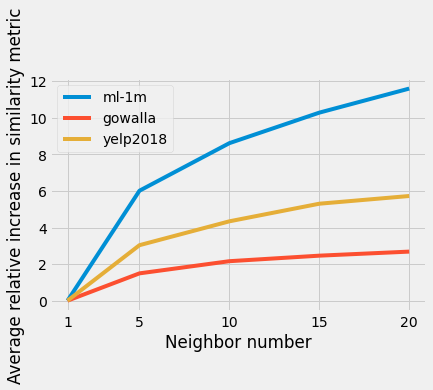

defaultdict(<class 'list'>, {'ml-1m': array([ 0.        ,  6.01098559,  8.61229143, 10.28085812, 11.59705669]), 'gowalla': array([0.        , 1.4920859 , 2.15747555, 2.4599254 , 2.68172195]), 'yelp2018': array([0.        , 3.03270042, 4.33808017, 5.30063291, 5.72257384])})

    \begin{figure*}[t!]
    \begin{center}
    \begin{tikzpicture}[scale=0.6]
    \begin{axis}[
        %title={Average relative increase in "hamming" similarity metric},
        title={},
        xlabel={Nearest Neighbor number},
        ylabel={Average relative increase, \%},
        xmin=1, xmax=20 ,
ymin=0, ymax=12.176909524303058,  
  xtick={1,5,10,15,20},
    ytick={0.0,1.4174180398659644,2.8348360797319287,4.252254119597893,5.6696721594638575,7.087090199329822,8.504508239195786,9.92192627906175,11.339344318927715,12.75676235879368},
legend pos=north west,
        ymajorgrids=true,
        grid style=dashed,
    ]
    
        \addplot[
            color=blue,
            mark=square,
            ]
           

100%|██████████| 100/100 [00:00<00:00, 198.32it/s]


6.791556947825628 [0.         3.63557483 5.26514343 6.15322431 6.79155695]


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


8.06453190163612 [0.         5.3859236  6.79023745 7.52894403 8.0645319 ]


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]

8.06453190163612 [0.         2.97083136 4.41372192 5.13574784 5.70849464]


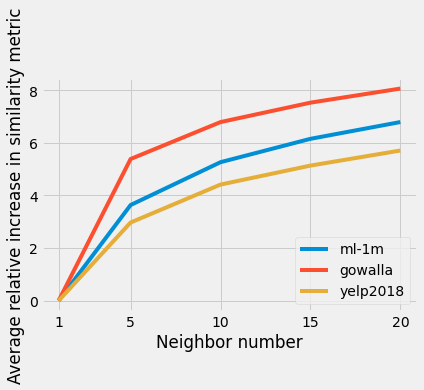

defaultdict(<class 'list'>, {'ml-1m': array([0.        , 3.63557483, 5.26514343, 6.15322431, 6.79155695]), 'gowalla': array([0.        , 5.3859236 , 6.79023745, 7.52894403, 8.0645319 ]), 'yelp2018': array([0.        , 2.97083136, 4.41372192, 5.13574784, 5.70849464])})

    \begin{figure*}[t!]
    \begin{center}
    \begin{tikzpicture}[scale=0.6]
    \begin{axis}[
        %title={Average relative increase in "angular" similarity metric},
        title={},
        xlabel={Nearest Neighbor number},
        ylabel={Average relative increase, \%},
        xmin=1, xmax=20 ,
ymin=0, ymax=8.467758496717925,  
  xtick={1,5,10,15,20},
    ytick={0.0,0.9856650101999702,1.9713300203999404,2.9569950305999106,3.942660040799881,4.928325050999851,5.913990061199821,6.899655071399792,7.885320081599762,8.870985091799731},
legend pos=north west,
        ymajorgrids=true,
        grid style=dashed,
    ]
    
        \addplot[
            color=blue,
            mark=square,
            ]
            coord

100%|██████████| 100/100 [00:00<00:00, 163.97it/s]


6.764628118449156 [0.         3.60598027 5.17059755 6.03232122 6.76462812]


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


6.764628118449156 [0.         2.2422837  2.87415214 3.25257112 3.48240837]


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]

6.764628118449156 [0.         2.43390197 3.48330778 3.97323689 4.35436548]


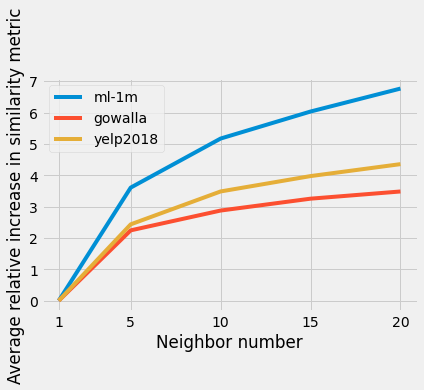

defaultdict(<class 'list'>, {'ml-1m': array([0.        , 3.60598027, 5.17059755, 6.03232122, 6.76462812]), 'gowalla': array([0.        , 2.2422837 , 2.87415214, 3.25257112, 3.48240837]), 'yelp2018': array([0.        , 2.43390197, 3.48330778, 3.97323689, 4.35436548])})

    \begin{figure*}[t!]
    \begin{center}
    \begin{tikzpicture}[scale=0.6]
    \begin{axis}[
        %title={Average relative increase in "euclidean" similarity metric},
        title={},
        xlabel={Nearest Neighbor number},
        ylabel={Average relative increase, \%},
        xmin=1, xmax=20 ,
ymin=0, ymax=7.102859524371614,  
  xtick={1,5,10,15,20},
    ytick={0.0,0.8267878811437859,1.6535757622875717,2.4803636434313576,3.3071515245751435,4.133939405718929,4.960727286862715,5.787515168006501,6.614303049150287,7.441090930294073},
legend pos=north west,
        ymajorgrids=true,
        grid style=dashed,
    ]
    
        \addplot[
            color=blue,
            mark=square,
            ]
            co

In [212]:
from matplotlib import pyplot as plt
from collections import defaultdict



for metric in ['hamming','angular','euclidean']:

    fig, ax = plt.subplots(1, 1)
    global_y_values = []
    max_dist = -1
    global_d = defaultdict(list)
    for path in ['ml-1m','gowalla','yelp2018']:

        train_matrix = sps.load_npz(f'../assets/clean/{path}/interactions.train.npz').toarray()

        index = AnnoyIndex(train_matrix.shape[1], metric)
        for i in tqdm(range(train_matrix.shape[0])):
            if train_matrix[i].sum():
                index.add_item(i, train_matrix[i])

        index.build(10) # 10 trees


        l = [1,2,3,4,5,6,7,8,9,10]
        avg_dist = []
        for n in nngb_list:
            distances = []
            for i in tqdm(range(train_matrix[:100].shape[0])):
                if train_matrix[i].sum():

                    dist = index.get_nns_by_vector(train_matrix[i],n=max(nngb_list)+10,include_distances=True)[1][1:]
                    distances.append(dist[n-1])

            avg_dist.append(np.mean(distances))
            global_d[path].append(np.mean(distances))

        avg_dist = np.array(avg_dist)
        avg_dist = ((avg_dist / avg_dist[0]) - 1 ) * 100

        max_dist = max(max_dist, max(avg_dist))
        print(max_dist, avg_dist)
        ax.plot(nngb_list, avg_dist, label=path)

        global_d[path] = np.array(global_d[path])
        global_d[path] = ((global_d[path] / global_d[path][0]-1)*100)

        global_y_values.extend(global_d[path])


    ax.set_xlabel('Neighbor number')
    ax.set_ylabel('Average relative increase in similarity metric')
    ax.set_xticks(nngb_list)
    ax.legend()
    plt.show()
    
    print(global_d)
    pattern = '''
    \\begin{figure*}[t!]
    \\begin{center}
    \\begin{tikzpicture}[scale=0.6]
    \\begin{axis}[
        %title={Average relative increase in "'''+ str(metric) + '''" similarity metric},
        title={},
        xlabel={Nearest Neighbor number},
        ylabel={Average relative increase, \%},
        xmin=1, xmax=''' + str(max(nngb_list))
    pattern += ''' ,\nymin=0, ymax=''' + str(1.05 * max_dist)+','


    pattern += '''  \n  xtick={'''+','.join(map(str,nngb_list))+'},\n'
    pattern += '''    ytick={'''+','.join(map(str,np.linspace(min(global_y_values),1.1* max(global_y_values), 10)))+'},\n'

    pattern += '''legend pos=north west,
        ymajorgrids=true,
        grid style=dashed,
    ]
    '''

    for color, path in zip(['blue','red','black'],['ml-1m','gowalla','yelp2018']):
        pattern += f'''
        \\addplot[
            color={color},
            mark=square,
            ]
            coordinates '''

        pattern += '{('+')('.join([f'{nngb_list[i]},{global_d[path][i]}' for i in range(len(nngb_list))])+')'
        pattern += '''};\n \\addlegendentry{'''+path+'''}'''

        

    pattern += '''\\end{axis}'''


    print(pattern)

In [59]:
global_dict2 = {}

for m in ['hamming','angular','euclidean']:

    global_y_values = []
    max_dist = -1
    global_d = defaultdict(list)
    for path in ['ml-1m']:

        train_matrix = sps.load_npz(f'../assets/clean/{path}/interactions.train.npz').toarray()

        

        recall = Recall(topk=[10, 20, 50, 100])
        ndcg = NDCG(topk=[10, 20, 50, 100])
        train_preds =  np.load(f'../assets/clean/{dataset}/{dataset}_ials/train_preds.npy')
        print(m)
        sp = SemiPers(train_matrix, train_preds, metric=m)
        preds = sp.predict(input_test, nngb=5)

        preds[input_test>0] = -np.inf
        ndcg(preds, output_test)
        recall(preds, output_test)

        for metric in (recall, ndcg):
            values = metric.get_metric()
            for key in values.keys():
                global_dict2[(dataset, 'ESPRec_'+"{"+model+','+m+'}', key)] = values[key]




hamming


100%|██████████| 4809/4809 [00:02<00:00, 2089.84it/s]


0 processed out of 638
100 processed out of 638
200 processed out of 638
300 processed out of 638
400 processed out of 638
500 processed out of 638
600 processed out of 638
angular


100%|██████████| 4809/4809 [00:02<00:00, 2260.41it/s]


0 processed out of 638
100 processed out of 638
200 processed out of 638
300 processed out of 638
400 processed out of 638
500 processed out of 638
600 processed out of 638
euclidean


100%|██████████| 4809/4809 [00:02<00:00, 2353.54it/s]


0 processed out of 638
100 processed out of 638
200 processed out of 638
300 processed out of 638
400 processed out of 638
500 processed out of 638
600 processed out of 638


In [ ]:


pattern = '''

 \\begin{table*}[t!]
 \caption{Performance comparison on three datasets. The best value is boldfaced.}
\label{benchmarkresults}
\\begin{tblr}{|l|c|c|c|c|c|c|}
\\toprule
  & \SetCell[c=2]{c} ML-1M  & & \SetCell[c=2]{c} Gowalla & & \SetCell[c=2]{c} Yelp2018 & \\\\ 
\cmidrule{1-7}
  &  RECALL@20& NDCG@20   &  RECALL@20& NDCG@20     &  RECALL@20& NDCG@20 \\\\
\midrule''' 

pattern += '''
   TopPop & m0000 &m0001& m0002 & m0003& m0004 & m0005\\\\
   $MultiVAE$  & m0006&m0007&m0008& m0009& m0010 & m0011 \\\\ 
   $EMAIR_{MultiVAE}$  & m0012&m0013&m0014& m0015& m0016 & m0017 \\\\ 
   $EASE$  & m0018&m0019&m0020& m0021& m0022 & m0023 \\\\
   $EMAIR_{EASE}$  & m0024&m0025&m0026& m0027& m0028 & m0029 \\\\ 
  % $RecVAE$  & m0030&m0031&m0032& m0033& m0034 & m0035 \\\\
  % $EMAIR_{RecVAE}$  & m0036&m0037&m0038& m0039& m0040 & m0041 \\\\ 
   $IALS$  & m0042&m0043&m0044& m0045& m0046 & m0047 \\\\ 
   '''

pattern += '''\\bottomrule
\end{tblr}
\end{table*} '''


for i in range(len(fills)):
    number = 'm' + ('000'+str(i))[-4:]
    if fills[i] == '-':
        pattern = pattern.replace(number,'-')
    else:
        pattern = pattern.replace(number, str(round(fills[i],3)))

print(pattern)

In [60]:
global_dict2

{('ml-1m', 'ESPRec_{ials,hamming}', 'recall@10'): 0.01576807539681002,
 ('ml-1m', 'ESPRec_{ials,hamming}', 'recall@20'): 0.03176607539589924,
 ('ml-1m', 'ESPRec_{ials,hamming}', 'recall@50'): 0.07562861025276475,
 ('ml-1m', 'ESPRec_{ials,hamming}', 'recall@100'): 0.14343481732028573,
 ('ml-1m', 'ESPRec_{ials,hamming}', 'ndcg@10'): 0.035929734443365904,
 ('ml-1m', 'ESPRec_{ials,hamming}', 'ndcg@20'): 0.04000951089614751,
 ('ml-1m', 'ESPRec_{ials,hamming}', 'ndcg@50'): 0.05673408891330182,
 ('ml-1m', 'ESPRec_{ials,hamming}', 'ndcg@100'): 0.08328092830942418,
 ('ml-1m', 'ESPRec_{ials,angular}', 'recall@10'): 0.02056266748095331,
 ('ml-1m', 'ESPRec_{ials,angular}', 'recall@20'): 0.03727707317302191,
 ('ml-1m', 'ESPRec_{ials,angular}', 'recall@50'): 0.07326300123483204,
 ('ml-1m', 'ESPRec_{ials,angular}', 'recall@100'): 0.13028445342244538,
 ('ml-1m', 'ESPRec_{ials,angular}', 'ndcg@10'): 0.030917754018636348,
 ('ml-1m', 'ESPRec_{ials,angular}', 'ndcg@20'): 0.03590394178381952,
 ('ml-1m', 'E